# 最小平方误差(LMSE)算法

原理：待补充

### 数据集加载
导入库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_classification

p维数据集生成

In [2]:
def generate_dataset(p, n_samples=100, mean_gap=2.0, random_state=None):
    """
    生成线性可分的最小二乘分类数据集
    :param p: 样本维度（特征数）
    :param n_samples: 样本总数（将平均分配到两类）
    :param mean_gap: 类间中心距离，用于控制可分性
    :param random_state: 随机种子（可选）
    :return: 
        X: 样本矩阵 [n_samples, p]
        y: 标签向量 [n_samples], 取值 {-1, +1}
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_half = n_samples // 2  # 每类一半
    
    # 类别 1：均值 +mean_gap
    mean_pos = np.ones(p) * mean_gap
    cov = np.eye(p)  # 单位协方差
    X_pos = np.random.multivariate_normal(mean_pos, cov, n_half)
    y_pos = np.ones(n_half)
    
    # 类别 2：均值 -mean_gap
    mean_neg = -np.ones(p) * mean_gap
    X_neg = np.random.multivariate_normal(mean_neg, cov, n_half)
    y_neg = -np.ones(n_half)
    
    # 合并
    X = np.vstack((X_pos, X_neg))
    y = np.concatenate((y_pos, y_neg))
    
    # 打乱顺序
    idx = np.random.permutation(n_samples)
    X, y = X[idx], y[idx]
    
    return X, y

### LMSE 数据增广处理

In [3]:
def augmentation(X, y):
    """
    对 X 进行最小平方误差增广处理（在最后一列添加常数 1 并乘上 y），以将偏置项 b 统一并入参数向量 W 中。
    :param X: 输入样本 [n_samples, p]
    :param y: 样本标签 [n_samples]
    :return: X: 增广样本 [n_samples, p + 1]
    """
    X_aug = np.hstack((X, np.ones((X.shape[0], 1)))) * y.reshape(-1, 1)
    return X_aug

In [4]:
# 输入：3 个样本，每个样本 2 个特征
X = np.array([
    [2.0, 3.0],
    [-1.0, 4.0],
    [0.0, -2.0]
])
y = np.array([1, 1, -1])

X_aug = augmentation(X, y)
print("原始形状:", X.shape)
print("增广后形状:", X_aug.shape)
print("增广后矩阵:\n", X_aug)

原始形状: (3, 2)
增广后形状: (3, 3)
增广后矩阵:
 [[ 2.  3.  1.]
 [-1.  4.  1.]
 [-0.  2. -1.]]


### 最小二乘法

计算逆与伪逆

In [5]:
def calculate_inv(A, tol=1e-10):
    """
    计算输入矩阵的逆或者伪逆
    :param A: 输入矩阵 [m, n]
    :param tol: 判断奇异的容差（默认1e-10）
    :return: A_inv，即A的逆或者伪逆
    """
    A = np.asarray(A)
    
    # --- 判断矩阵是否为方阵 ---
    m, n = A.shape
    if m == n:
        # 计算条件数 condition number
        cond_num = np.linalg.cond(A)
        
        # 条件数过大 → 近似奇异，用伪逆
        if cond_num < 1 / tol:
            A_inv = np.linalg.inv(A)
        else:
            print("⚠️ 矩阵接近奇异，使用伪逆代替求逆。")
            A_inv = np.linalg.pinv(A)
    else:
        # 非方阵直接求伪逆
        A_inv = np.linalg.pinv(A)
    
    return A_inv

最小二乘法

In [13]:
def LMSE(X_aug, y):
    """
    通过最小二乘法计算最佳的权重 W
    :param X: 输入增广样本 [n_samples, p+1]
    :param y: 样本标签 [n_samples]
    :return: 权重矩阵 W [p+1, 1]
    """
    X_aug_inv = calculate_inv(X_aug)
    W = X_aug_inv @ y.reshape(-1, 1)
    return W

In [14]:
X = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])

y = np.array([1, 1, -1, -1])

X_aug = np.hstack((X, np.ones((X.shape[0], 1))))
print(X_aug)

W = LMSE(X_aug, y)
print(W)

[[0. 0. 1.]
 [0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 1.]]
[[-2.00000000e+00]
 [ 5.55111512e-16]
 [ 1.00000000e+00]]


L2正则化（岭回归）

In [15]:
def LMSE_Ridge(X_aug, y, lambd=0.1, bias_penalty=False):
    """
    通过岭回归计算最优权重 W
    :param X: 增广样本矩阵 [n_samples, p+1]
    :param y: 样本标签 [n_samples]
    :param lambd: 正则化系数 λ
    :param bias_penalty: 是否惩罚偏置项
    :return: 权重矩阵 W [p+1, 1], 增广样本逆或者伪逆 X_aug_inv
    """
    I = np.eye(X_aug.shape[1])
    if not bias_penalty:
        I[0, 0] = 0  # 不惩罚偏置
    A = X_aug.T @ X_aug + lambd * I
    b = X_aug.T @ y.reshape(-1, 1)
    W = np.linalg.solve(A, b)
    return W

In [16]:
X = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])

y = np.array([1, 1, -1, -1])
X_aug = np.hstack((X, np.ones((X.shape[0], 1))))

W = LMSE_Ridge(X_aug, y)
print(W)

[[-1.95338983]
 [ 0.04237288]
 [ 0.93220339]]


### Ho-Kashyap(H-K)算法
可以把 H–K 算法写作一个约束最优化问题：

$$
\begin{aligned}
\min_{w,b}\quad & J(w,b) = \frac{1}{2}\|Xw - b\|^2 \\
\text{s.t.}\quad & b \ge \epsilon \mathbf{1},\ \epsilon>0
\end{aligned}
$$

这就是**带不等式约束的最小二乘问题**。

In [30]:
def fit(X_aug, epoches = 10, learning_rate = 0.001):
    """
    由最小二乘法获取权重矩阵初值，然后使用类似感知机算法进行调整
    :param X_aug: 输入增广样本 [n_samples, p+1]
    :param epoches: 迭代次数
    :param learning_rate: 学习率
    :return: 训练过程 W 列表 [W1, W2, ..., Wk]
    """
    n_samples = X_aug.shape[0]
    
    # 计算逆或伪逆并初始化参数
    X_aug_inv = calculate_inv(X_aug)
    b = np.ones((n_samples, 1))
    W = LMSE_Ridge(X_aug, b)
    
    W_list = [W.copy()]
    for i in range(epoches):
        e = X_aug @ W - b
        W += learning_rate * (X_aug_inv @ np.abs(e))
        b += learning_rate * (e + np.abs(e))
        W_list.append(W.copy())
        
    return W_list

In [45]:
X = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])
y = np.array([1, 1, -1, -1])

X_aug = augmentation(X, y)
W_list = fit(X_aug)
print(W_list[-1])

[[-1.95406428]
 [ 0.04216149]
 [ 0.93277309]]


### 测试
#### （1）二维分类

Classification Accuracy: 100.00%


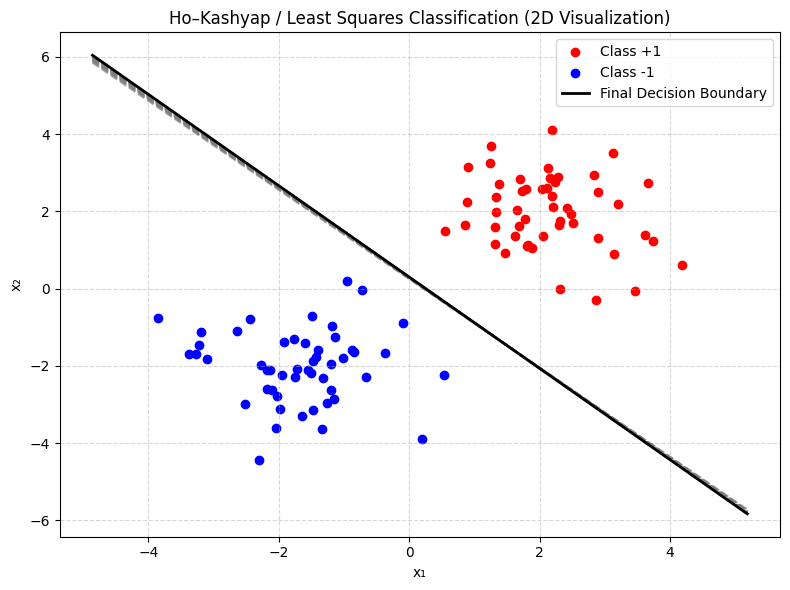

In [42]:
X, y = generate_dataset(2, n_samples=100, mean_gap=2.0, random_state=1)
X_aug = augmentation(X, y)
W_list = fit(X_aug, epoches=20, learning_rate=0.05)

# 提取最终权重
W_final = W_list[-1].flatten()
w1, w2, w0 = W_final  # 这里W = [w1, w2, w0]^T（偏置在最后）

# 计算分类准确率
y_pred = np.sign(X @ W_final[:-1] + W_final[-1])
accuracy = np.mean(y_pred == y)
print(f"Classification Accuracy: {accuracy*100:.2f}%")

plt.figure(figsize=(8, 6))
plt.title("Ho–Kashyap / Least Squares Classification (2D Visualization)")
plt.xlabel("x₁")
plt.ylabel("x₂")

# 绘制样本点
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="red", label="Class +1")
plt.scatter(X[y == -1, 0], X[y == -1, 1], c="blue", label="Class -1")

# 生成 x 轴取值范围
x_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200)

# 绘制每轮迭代的边界（灰色虚线）
for i, W in enumerate(W_list):
    w1, w2, w0 = W.flatten()  # ✅ 偏置在最后
    # 超平面方程: w1*x1 + w2*x2 + w0 = 0 → x2 = -(w1*x1 + w0)/w2
    y_vals = -(w1 * x_vals + w0) / w2
    alpha = 0.15 + 0.85 * (i + 1) / len(W_list)
    plt.plot(x_vals, y_vals, '--', color='gray', alpha=alpha)

# 绘制最终分类边界（黑色实线）
w1, w2, w0 = W_list[-1].flatten()
y_vals_final = -(w1 * x_vals + w0) / w2
plt.plot(x_vals, y_vals_final, color='black', linewidth=2, label='Final Decision Boundary')

# 布局与美化
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### （2）3维分类

Classification Accuracy: 100.00%


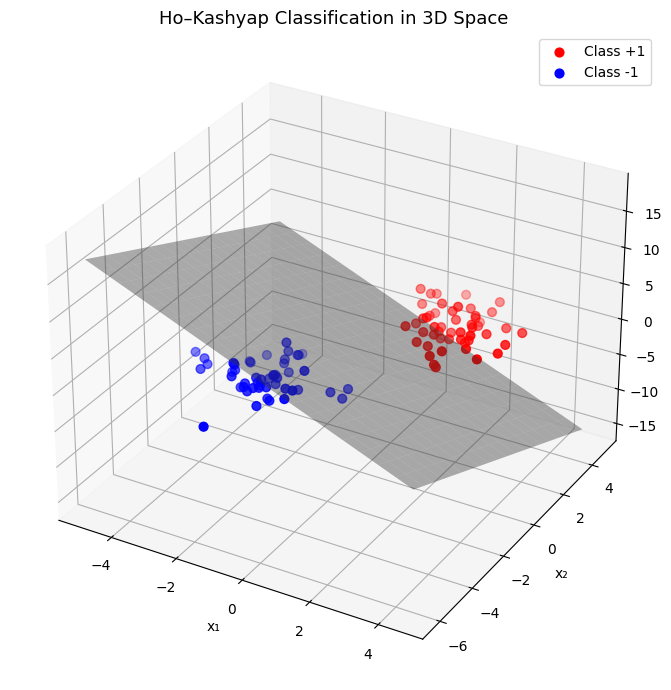

In [43]:
X, y = generate_dataset(3, n_samples=100, mean_gap=2.0, random_state=42)
X_aug = augmentation(X, y)
W_list = fit(X_aug, epoches=20, learning_rate=0.05)

# 提取最终权重
W_final = W_list[-1].flatten()
w1, w2, w3, w0 = W_final  # 这里W = [w1, w2, w3, w0]^T（偏置在最后）

# 计算分类准确率
y_pred = np.sign(X @ W_final[:-1] + W_final[-1])
accuracy = np.mean(y_pred == y)
print(f"Classification Accuracy: {accuracy*100:.2f}%")

# === 3D 可视化 ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Ho–Kashyap Classification in 3D Space", fontsize=13)
ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
ax.set_zlabel("x₃")

# 绘制样本点
ax.scatter(X[y == 1, 0], X[y == 1, 1], X[y == 1, 2], c="red", label="Class +1", s=40)
ax.scatter(X[y == -1, 0], X[y == -1, 1], X[y == -1, 2], c="blue", label="Class -1", s=40)

# === 绘制决策平面 ===
# 生成网格数据
x1_range = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 20)
x2_range = np.linspace(X[:,1].min()-1, X[:,1].max()+1, 20)
X1, X2 = np.meshgrid(x1_range, x2_range)

# 平面方程：w1*x1 + w2*x2 + w3*x3 + w0 = 0 → x3 = -(w1*x1 + w2*x2 + w0)/w3
X3 = -(w1 * X1 + w2 * X2 + w0) / w3

# 绘制平面
ax.plot_surface(X1, X2, X3, alpha=0.4, color="gray", edgecolor="none")

# 图例与布局
ax.legend()
plt.tight_layout()
plt.show()